In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from xmitgcm import utils
from xmitgcm import open_mdsdataset
from xgcm import Grid
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar

In [2]:
from astropy.time import Time

In [3]:
data_dir = "/pool001/xruan/RT_canyon_hydrostatic/diag/"
grid_dir = "/pool001/xruan/RT_canyon_hydrostatic/input/"
ds = open_mdsdataset(data_dir, grid_dir = grid_dir, iters="all", ignore_unknown_vars=True, prefix=["TS_inst", "tracer_inst"], delta_t = 5.)
ds = ds.drop_dims(["XG", "YG", "Zp1", "Zl", "Zu"])
grid = Grid(ds, periodic=['X', 'Y'])
ds['time'] = ds['time'] + np.datetime64('2021-06-27T00:00:00')
ds['THETA'].attrs['units'] = '°C'
ds['TRAC01'].attrs['release'] = '2021-07-01T04:00:00'
time_release = np.datetime64(ds['TRAC01'].attrs['release'])
final_time = time_release + np.timedelta64(42,'h')

ds = ds.assign_coords({'hours_since_release': ((ds['time'] - time_release)/(1.e9)).astype('float64')/3600.})

In [4]:
# Only need times between release and end of FCTD surveys
ds = ds.sel(time=slice(time_release - np.timedelta64(3,'h'), final_time))

# Small chunks to make xhistogram happy
ds = ds.chunk({'Z':10})

(-1900.0, -1700.0)

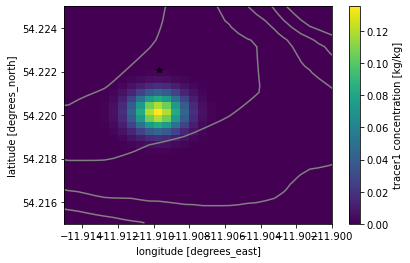

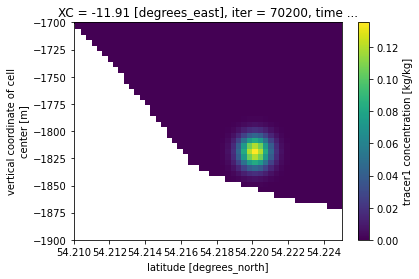

In [5]:
plt.figure()
ds['TRAC01'].sel(Z=-1800, method="nearest").isel(time=2).plot()
ds['Depth'].sel(XC=slice(-11.92, -11.89), YC=slice(54.215, 54.226)).plot.contour(levels=[1780, 1800, 1820, 1840, 1860], colors='gray')
plt.xlim(-11.915, -11.9)
plt.ylim(54.215, 54.225)

actual_release = (-11.9097, 54.2221)

plt.plot(actual_release[0], actual_release[1], "k*", label="actual release")

plt.figure()
ds['TRAC01'].where(ds['hFacC']!=0).sel(XC=-11.912, method="nearest").isel(time=0).plot()
plt.xlim(54.21, 54.225)
plt.ylim(-1900, -1700)

##### Notes from Bethan

>The dye release was on July 1st 2021, 3:01am at 54.22 N, -11.91 W. The depth was ~10m above the bottom at a temperature of 3.76℃.

>I’ve attached two files for the FCTD times and locations. The first (FCTD_dye_locations.mat) has the times and locations for the whole dye experiment. However, these locations correspond to the ship not the FCTD itself. The second (FCTD_transects.mat) is a structure containing information for the separate transect that was completed up, down or across the canyon. Each transect is it’s own structure named as the direction relative to the canyon and the repetition of that line. Within a transect’s structure is the time of the cast, the latitude of the FCTD fish and the longitude of the FCTD fish. The variable fish_depth is the maximum depth of the FCTD. The variable ind is the indices of that transect within the full timeseries contained in FCTD_dye_locations.mat.  You can ignore the variable ‘along_km’. 
It was a little tricky getting the exact location of the FCTD as it was being towed behind us, so apologies if some of the locations seem a bit off. 
Hopefully this all makes sense, please reach out if not or if there’s anything else you’d like! 

In [6]:
import scipy.io as sio
import astropy

In [7]:
fctd = sio.loadmat("data/FCTD_transects.mat", simplify_cells=True)['transects']

def get_trajectory(tjname):
    try:
        lon = fctd[tjname]['fctd_lon']
        lat = fctd[tjname]['fctd_lat']
        time = fctd[tjname]['time']
    except:
        lon = fctd[tjname]['fish_lon']
        lat = fctd[tjname]['fish_lat']
        time = fctd[tjname]['time']

    t0 = Time(0.0000, format="decimalyear", scale='utc').plot_date - 1.; # shift by one day to convert to matlab datenum format
    time = (Time(t0 + time , format='plot_date', scale='utc').datetime).astype("datetime64")
    
    trajectory = xr.Dataset({
        'XC': xr.DataArray(lon + 1.e-8*np.random.rand(lon.size), dims='cast'),
        'YC': xr.DataArray(lat + 1.e-8*np.random.rand(lon.size), dims='cast'),
        'time': xr.DataArray(time, dims='cast')
    })
    return trajectory

In [8]:
transects = {}

for k,v in fctd.items():
    if k=="timeseries": continue
    with ProgressBar():
        transects[k] = ds.interp(get_trajectory(k)).compute()

/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed | 55.4s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed |  1min 12.4s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed | 41.4s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed |  1min 32.5s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed |  1min  3.9s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed |  1min 21.0s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed |  1min 25.1s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed | 54.8s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed |  1min  6.6s
[                                        ] | 0% Completed |  0.0s

/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed | 21.4s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed | 57.8s


/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/hdrake/.conda/envs/rockall/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[########################################] | 100% Completed | 29.8s


In [9]:
time_release = np.datetime64('2021-07-01T04:00:00')
dsmom = xr.open_dataset("data/tracer_stats.nc").sel(time=slice(time_release, None))
dsmom_short = dsmom.sel(time=slice(time_release, final_time))

In [10]:
tmom = ((dsmom_short['time']-time_release)*1e-9).astype('float')
dTdtmom, T0fitmom = np.polyfit(tmom, dsmom_short['THETA_bar'], 1.)

In [11]:
t = np.array([]).astype("datetime64[ns]")
Tbar = np.array([])
for k,v in transects.items():
    transects[k].attrs['Tbar'] = (v['THETA']*v['TRAC01']*v['drF']).sum()/(v['TRAC01']*v['drF']).sum()
    t = np.append(t, v['time'].mean())
    Tbar = np.append(Tbar, transects[k].attrs['Tbar'])

In [12]:
tsec = ((t-time_release)*1e-9).astype('float')
dTdt, T0fit = np.polyfit(tsec, Tbar, 1.)

(3.725, 4.15)

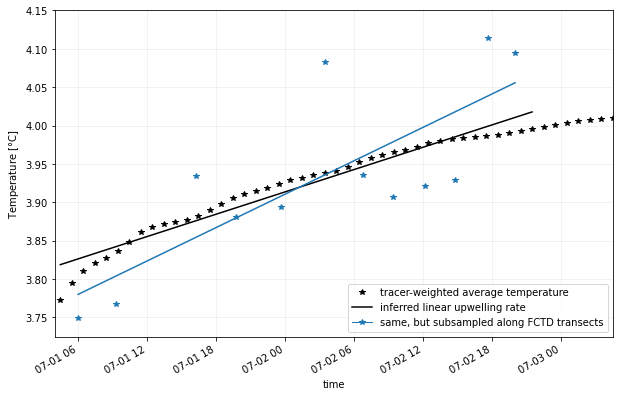

In [13]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot()

dsmom['THETA_bar'].plot(marker="*", color="k", linewidth=0., label="tracer-weighted average temperature")
plt.plot(dsmom_short['time'], dTdtmom*tmom + T0fitmom, "k-", label="inferred linear upwelling rate")

plt.plot([], [], "*-", linewidth=1, label="same, but subsampled along FCTD transects")
plt.plot(t, Tbar, "C0*")
plt.plot(t, dTdt*tsec + T0fit, "C0-")

plt.xlim(time_release, dsmom['time'][48])
plt.grid(True, alpha=0.2)
plt.ylabel("Temperature [$\degree$C]")
plt.legend(loc="lower right")
plt.ylim(3.725, 4.15)